<a href="https://colab.research.google.com/github/Allen123321/DEMO-DL/blob/master/Task_6_Model_integration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 任务
+ 学习集成学习方法以及交叉验证情况下的模型集成
+ 学会使用深度学习模型的集成学习

## 集成学习方法
常见的集成学习方法有Stacking、Bagging和Boosting，这些集成学习方法与具体验证集划分联系紧密。

由于深度学习模型一般需要较长的训练周期，如果硬件设备不允许建议选取留出法，如果需要追求精度可以使用交叉验证的方法。

10折交叉验证，训练得到10个语义分割模型。

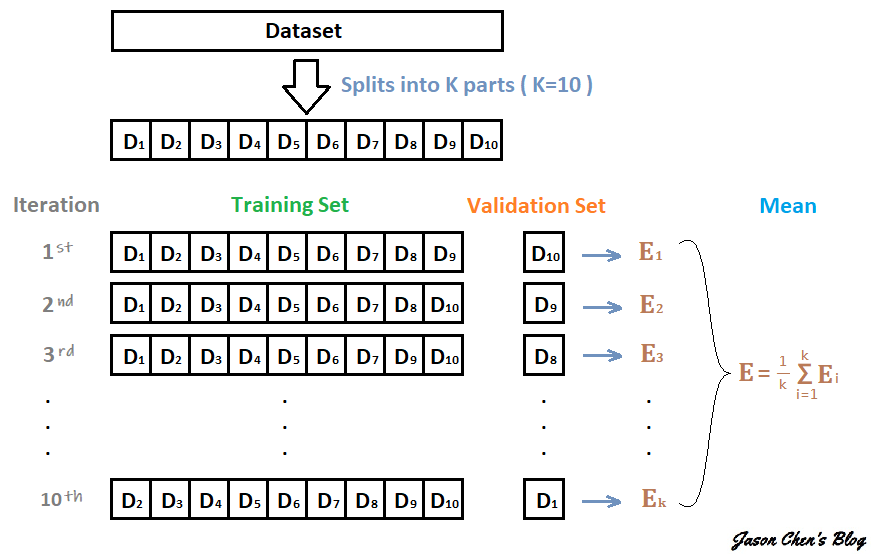

那么在10个CNN模型可以使用如下方式进行集成：

+ 对预测的结果的概率值进行平均，然后解码为具体字符；
+ 对预测的字符进行投票，得到最终字符；

### 深度学习中的集成学习

#### Dropout
Dropout可以作为训练深度神经网络的一种技巧。在每个训练批次中，通过随机让一部分的节点停止工作。同时在预测的过程中让所有的节点都其作用。
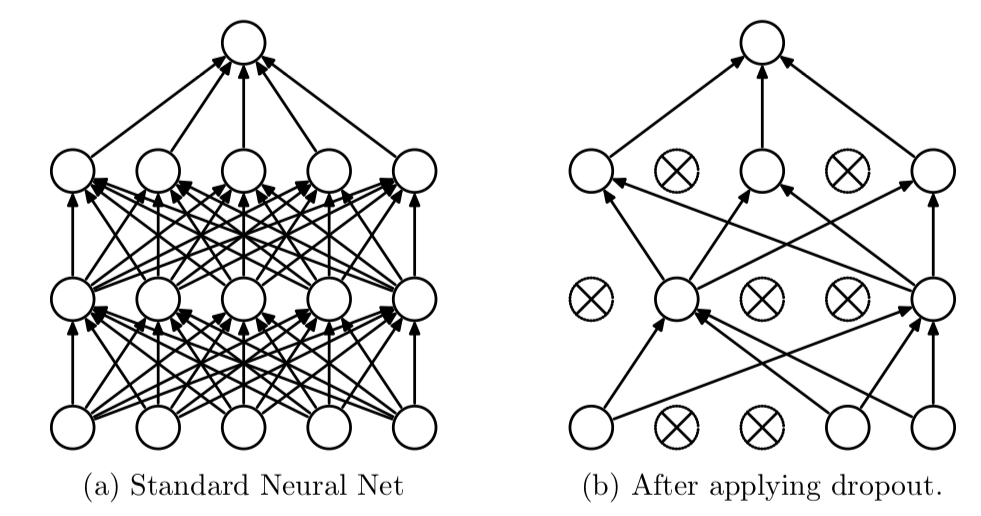

Dropout经常出现在在先有的CNN网络中，可以有效的缓解模型过拟合的情况，也可以在预测时增加模型的精度。

## TTA

测试集数据扩增（Test Time Augmentation，简称TTA）也是常用的集成学习技巧，数据扩增不仅可以在训练时候用，而且可以同样在预测时候进行数据扩增，对同一个样本预测三次，然后对三次结果进行平均。

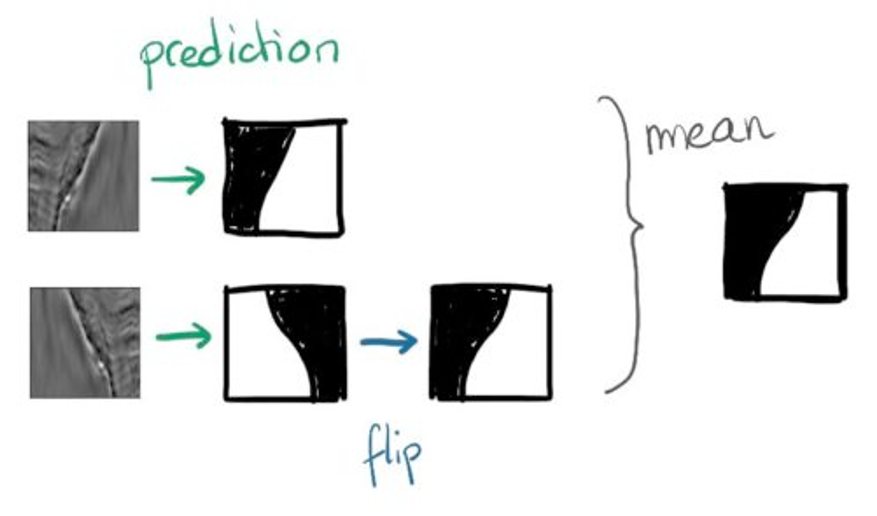



```
for idx, name in enumerate(tqdm_notebook(glob.glob('./test_mask/*.png')[:])):
    image = cv2.imread(name)
    image = trfm(image)
    with torch.no_grad():
        image = image.to(DEVICE)[None]
        score1 = model(image).cpu().numpy()
        
        score2 = model(torch.flip(image, [0, 3]))
        score2 = torch.flip(score2, [3, 0]).cpu().numpy()

        score3 = model(torch.flip(image, [0, 2]))
        score3 = torch.flip(score3, [2, 0]).cpu().numpy()
        
        score = (score1 + score2 + score3) / 3.0
        score_sigmoid = score[0].argmax(0) + 1
```



## Snapshot

论文Snapshot Ensembles中，作者提出使用cyclical learning rate进行训练模型，并保存精度比较好的一些checkopint，最后将多个checkpoint进行模型集成。

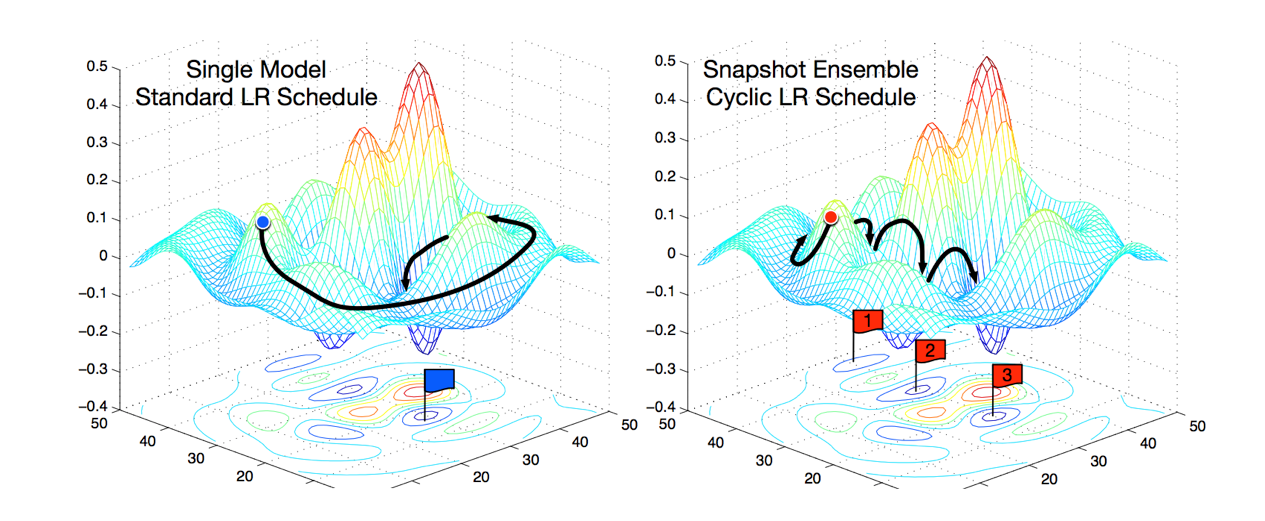

在cyclical learning rate中学习率的变化有周期性变大和减少的行为，因此CNN模型很有可能在跳出局部最优进入另一个局部最优。在Snapshot论文中作者通过使用表明，此种方法可以在一定程度上提高模型精度，但需要更长的训练时间。

获取k折交叉验证某一折的训练集和验证集

In [ ]:
def get_kfold_data(k, i, X, y):  
     
    # 返回第 i+1 折 (i = 0 -> k-1) 交叉验证时所需要的训练和验证数据，X_train为训练集，X_valid为验证集
    fold_size = X.shape[0] // k  # 每份的个数:数据总条数/折数（组数）
    
    val_start = i * fold_size
    if i != k - 1:
        val_end = (i + 1) * fold_size
        X_valid, y_valid = X[val_start:val_end], y[val_start:val_end]
        X_train = torch.cat((X[0:val_start], X[val_end:]), dim = 0)
        y_train = torch.cat((y[0:val_start], y[val_end:]), dim = 0)
    else:  # 若是最后一折交叉验证
        X_valid, y_valid = X[val_start:], y[val_start:]     # 若不能整除，将多的case放在最后一折里
        X_train = X[0:val_start]
        y_train = y[0:val_start]
        
    return X_train, y_train, X_valid,y_valid

模型训练

In [ ]:
def traink(model, X_train, y_train, X_val, y_val, BATCH_SIZE, learning_rate, TOTAL_EPOCHS):
    
    train_loader = DataLoader(TensorDataset(X_train,y_train), BATCH_SIZE, shuffle = True)
    val_loader = DataLoader(TensorDataset(X_val, y_val), BATCH_SIZE, shuffle = True)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(params = model.parameters(), lr = learning_rate)

    losses = []
    val_losses = []
    train_acc = []
    val_acc = []
	
    for epoch in range(TOTAL_EPOCHS):
        model.train()
        correct = 0   # 记录正确的个数，每个epoch训练完成之后打印accuracy
        for i, (images, labels) in enumerate(train_loader):
            images = images.float()
            labels = torch.squeeze(labels.type(torch.LongTensor))
            optimizer.zero_grad()        # 清零
            outputs = model(images)
            # 计算损失函数
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            # 计算正确率
            y_hat = model(images)
            pred = y_hat.max(1, keepdim = True)[1]
            correct += pred.eq(labels.view_as(pred)).sum().item()
            
            if (i+1) % 10 == 0:
            # 每10个batches打印一次loss
                print ('Epoch : %d/%d, Iter : %d/%d,  Loss: %.4f'%(epoch + 1, TOTAL_EPOCHS, 
                                                                   i + 1, len(X_train)//BATCH_SIZE, 
                                                                   loss.item()))
        accuracy = 100.*correct/len(X_train)
        print('Epoch: {}, Loss: {:.5f}, Training set accuracy: {}/{} ({:.3f}%)'.format(
            epoch + 1, loss.item(), correct, len(X_train), accuracy))
        train_acc.append(accuracy)
        
        
        # 每个epoch计算测试集accuracy
        model.eval()
        val_loss = 0
        correct = 0
        with torch.no_grad():
            for i, (images, labels) in enumerate(val_loader):          
                images = images.float()
                labels = torch.squeeze(labels.type(torch.LongTensor))
                optimizer.zero_grad()
                y_hat = model(images)
                loss = criterion(y_hat, labels).item()      # batch average loss
                val_loss += loss * len(labels)             # sum up batch loss 
                pred = y_hat.max(1, keepdim = True)[1]      # get the index of the max log-probability
                correct += pred.eq(labels.view_as(pred)).sum().item()
        
        val_losses.append(val_loss/len(X_val))
        accuracy = 100.*correct/len(X_val)
        print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
            val_loss, correct, len(X_val), accuracy))
        val_acc.append(accuracy)
        
        
    return losses, val_losses, train_acc, val_acc

k折交叉验证：

In [ ]:
def k_fold(k, X_train, y_train, num_epochs = 3, learning_rate = 0.0001, batch_size = 16):
    
    train_loss_sum, valid_loss_sum = 0, 0
    train_acc_sum , valid_acc_sum = 0, 0
    
    for i in range(k):
        print('*'*25,'第', i + 1,'折','*'*25)
        data = get_kfold_data(k, i, X_train, y_train)    # 获取k折交叉验证的训练和验证数据
        net = Net()  # 实例化模型（某已经定义好的模型）
        # 每份数据进行训练
        train_loss, val_loss, train_acc, val_acc = traink(snet, *data, batch_size, learning_rate,  num_epochs) 
       
        
        print('train_loss:{:.5f}, train_acc:{:.3f}%'.format(train_loss[-1], train_acc[-1]))
        print('valid loss:{:.5f}, valid_acc:{:.3f}%\n'.format(val_loss[-1], val_acc[-1]))
        
        train_loss_sum += train_loss[-1]
        valid_loss_sum += val_loss[-1]
        train_acc_sum += train_acc[-1]
        valid_acc_sum += val_acc[-1]
        
    print('\n', '#'*10,'最终k折交叉验证结果','#'*10) 
    

    print('average train loss:{:.4f}, average train accuracy:{:.3f}%'.format(train_loss_sum/k, train_acc_sum/k))
    print('average valid loss:{:.4f}, average valid accuracy:{:.3f}%'.format(valid_loss_sum/k, valid_acc_sum/k))

    return 